In [1]:
# Standard python imports
import os
import h5py
import numpy as np
from tqdm import tqdm, tnrange, tqdm_notebook

# My module imports
import utils

# Keras, tf, and sklear
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, AvgPool2D
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Make reproducible
SEED = 32
np.random.seed(SEED)
tf.set_random_seed(SEED)

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Data Processing

In [2]:
# Maybe get the data .mat file
if not os.path.isfile("data.mat"):
    !wget https://www.dropbox.com/s/b1bnrj2f30xe1ns/xq_data_big.mat?dl=0
    !mv 'xq_data_big.mat?dl=0' data.mat

# Import the data from file
f = h5py.File("data.mat")
data, labels = np.array(f['data']), np.array(f['labels'])
f.close()

In [3]:
# Get rid of zero columns
colInds = np.sum(data, axis=0) != 0.0
data = data[:, colInds]

# Normalize
data = np.log1p(data)

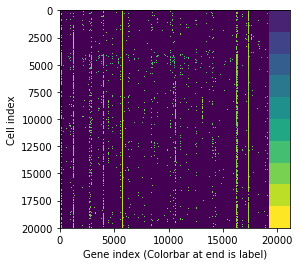

In [4]:
# Visualize data with labels
labels_scaled = labels * (data.max() - data.min()) / labels.max() - data.min()
plt.imshow(np.hstack((data, np.repeat(labels_scaled, data.shape[1] //  10, axis=1))))
plt.xlabel("Gene index (Colorbar at end is label)")
plt.ylabel("Cell index");

In [5]:
# Parameters to use for the rest of this workflow
BATCH_SIZE = 60
TEST_PROP = 0.1
VAL_PROP = 0.1
NCLASS = 10
NFEATURES = data.shape[1]

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


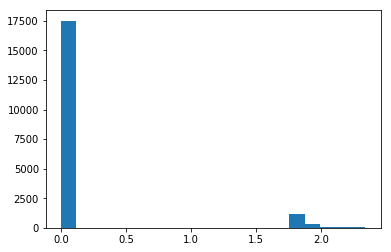

In [6]:
# Get test and training
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=TEST_PROP)

# Convert labels to one-hot format
train_labels = (np.arange(NCLASS) == train_labels).astype(np.float32)
test_labels = (np.arange(NCLASS) == test_labels).astype(np.float32)

# Sanity check to make sure data is not crazy
plt.subplot(111).hist(train_data[0].flatten(), bins=20)
print(train_labels[0])

In [7]:
# Reshape the data
test_data = test_data[:, :, None, None]
train_data = train_data[:, :, None, None]

# Model Definition

In [8]:
model = Sequential()

model.add(Convolution2D(16, (10, 1), activation='relu', input_shape=(NFEATURES,1,1), padding='same'))
model.add(AvgPool2D(pool_size=(2,1)))
model.add(Convolution2D(16, (10, 1), activation='relu', padding='same'))
model.add(AvgPool2D(pool_size=(4,1)))
model.add(Convolution2D(32, (10, 1), activation='relu', padding='same'))
model.add(AvgPool2D(pool_size=(4,1)))
model.add(Convolution2D(64, (2, 1), activation='relu', padding='valid'))
model.add(AvgPool2D(pool_size=(12,1)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Training / Evaluation

In [10]:
 # 9. Fit model on training data
model.fit(train_data, train_labels, 
          batch_size=BATCH_SIZE, epochs=5,\
          validation_split=0.1, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 16200 samples, validate on 1800 samples
Epoch 1/5
16200/16200 [==============================] - 92s 6ms/step - loss: 1.4634 - acc: 0.3535 - val_loss: 0.9622 - val_acc: 0.5611
Epoch 2/5
16200/16200 [==============================] - 92s 6ms/step - loss: 0.9560 - acc: 0.5257 - val_loss: 0.7533 - val_acc: 0.6000
Epoch 3/5
16200/16200 [==============================] - 91s 6ms/step - loss: 0.8074 - acc: 0.5797 - val_loss: 0.6701 - val_acc: 0.6472
Epoch 4/5
16200/16200 [==============================] - 90s 6ms/step - loss: 0.7393 - acc: 0.6075 - val_loss: 0.6552 - val_acc: 0.6500
Epoch 5/5
16200/16200 [==============================] - 91s 6ms/step - loss: 0.6970 - acc: 0.6246 - val_loss: 0.6146 - val_acc: 0.6650


In [11]:
loss, acc = model.evaluate(test_data, test_labels)
print(f"Test loss: {loss}")
print(f"Test accuracy: {acc}")

2000/2000 [==============================] - 3s 2ms/step
Test loss: 0.6488686985969544
Test accuracy: 0.643


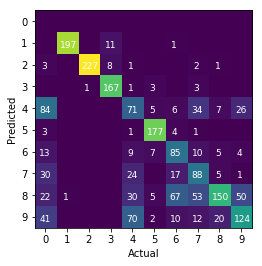

In [12]:
preds = model.predict(test_data)
conf = utils.confusions(preds, test_labels)
utils.plot_confusions(conf);